<a href="https://colab.research.google.com/github/arnavsinghal09/GSoC-QMAML/blob/main/Jet_Classification_with_different_Initialization_Techniques%20v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane h5py --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 67.8 MB/s eta 0:00:00


In [2]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pennylane as qml
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any
from dataclasses import dataclass, field
from sklearn.metrics import (accuracy_score,precision_score, recall_score, f1_score, classification_report, confusion_matrix)
from sklearn.metrics import ConfusionMatrixDisplay

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [3]:
# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Mount Google Drive (if running in Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# --- Cell 2: Configuration / Hyperparameter Setup ---
@dataclass
class Config:
    SAMPLES: int = 10000
    NUM_QUBITS: int = 6
    Q_DEPTH: int = 4
    ENCODING_SCHEME: str = 'angle'
    USE_ANALYTIC_GRADIENTS: bool = True
    CNN_OUTPUT_DIM: int = 256
    USE_PRETRAINED_CNN: bool = True
    INNER_STEPS: int = 6
    INNER_LR: float = 0.005
    OUTER_LR: float = 0.0005
    META_TASK_TYPE: List[str] = field(default_factory=lambda: ['pt', 'm0'])
    META_BIN_COUNT: int = 7
    SUPPORT_SIZE: int = 24
    QUERY_SIZE: int = 24
    EPOCHS: int = 15
    BATCH_SIZE: int = 24
    EVAL_METRICS: bool = True
    SAVE_BEST_MODEL: bool = False
    CHECKPOINT_DIR: str = '/content/drive/MyDrive/quark-gluon-checkpoints'

config = Config()
os.makedirs(config.CHECKPOINT_DIR, exist_ok=True)

In [6]:
# --- Cell 3: Dataset Loading ---
class JetDataset(Dataset):
    """Custom Dataset for loading jet images, labels, and additional features."""
    def __init__(self, X: np.ndarray, y: np.ndarray, pt: np.ndarray = None, m0: np.ndarray = None):
        self.X = X
        self.y = y
        self.pt = pt
        self.m0 = m0

    def __len__(self) -> int:
        return len(self.y)

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, int]:
        return self.X[idx], self.y[idx]

def load_and_merge_datasets(config: Config) -> Tuple[Dataset, Dataset]:
    """Load and merge datasets for meta-task generation."""
    # Paths to datasets
    train_path = '/content/drive/MyDrive/quark-gluon-dataset/quark-gluon_train-set_n793900.hdf5'
    test1_path = '/content/drive/MyDrive/quark-gluon-dataset/quark-gluon_test-set_n139306.hdf5'

    # Load train and test1 datasets
    with h5py.File(train_path, 'r') as f:
        X_train = f['X_jets'][:config.SAMPLES]
        y_train = f['y'][:config.SAMPLES]
        pt_train = f['pt'][:config.SAMPLES]
        m0_train = f['m0'][:config.SAMPLES]

    with h5py.File(test1_path, 'r') as f:
        X_test1 = f['X_jets'][:config.SAMPLES]
        y_test1 = f['y'][:config.SAMPLES]
        pt_test1 = f['pt'][:config.SAMPLES]
        m0_test1 = f['m0'][:config.SAMPLES]

    # Merge train and test1
    X_meta = np.concatenate([X_train, X_test1], axis=0)
    y_meta = np.concatenate([y_train, y_test1], axis=0)
    pt_meta = np.concatenate([pt_train, pt_test1], axis=0)
    m0_meta = np.concatenate([m0_train, m0_test1], axis=0)

    # Create dataset
    meta_dataset = JetDataset(X_meta, y_meta, pt_meta, m0_meta)
    return meta_dataset

# Load datasets
meta_dataset = load_and_merge_datasets(config)

In [7]:
# --- Cell 4: Meta-Task Generation ---
def generate_meta_tasks(
    dataset: Dataset,
    meta_task_types: List[str],  # List of meta-task types (e.g., ['pt', 'm0'])
    bin_count: int,
    support_size: int,
    query_size: int,
    num_tasks_per_bin: int = 3,  # Generate multiple tasks per bin
) -> List[Dict[str, Any]]:
    """
    Generate meta-tasks using both `pt` and `m0` features for diversity.
    Args:
        dataset: The dataset containing jet images and features.
        meta_task_types: List of meta-task types to use (e.g., ['pt', 'm0']).
        bin_count: Number of bins for meta-task generation.
        support_size: Size of the support set.
        query_size: Size of the query set.
        num_tasks_per_bin: Number of tasks to generate per bin.
    Returns:
        List of meta-tasks, each containing support and query sets.
    """
    X, y = [], []
    for i in range(len(dataset)):
        X_sample, y_sample = dataset[i]
        X.append(X_sample)
        y.append(y_sample)
    X = np.array(X)
    y = np.array(y)

    meta_tasks = []
    bin_task_counts = []

    # Alternate between `pt` and `m0` for meta-task generation
    for feature_type in meta_task_types:
        feature = getattr(dataset, feature_type)
        bins = np.linspace(feature.min(), feature.max(), bin_count + 1)
        for i in range(len(bins) - 1):
            bin_indices = np.where((feature >= bins[i]) & (feature < bins[i + 1]))[0]
            if len(bin_indices) < support_size + query_size:
                continue  # Skip bins with insufficient samples

            # Ensure balanced classes in support and query sets
            class_0_indices = bin_indices[y[bin_indices] == 0]
            class_1_indices = bin_indices[y[bin_indices] == 1]
            if len(class_0_indices) < support_size // 2 or len(class_1_indices) < support_size // 2:
                continue  # Skip bins with insufficient samples for balanced classes

            for _ in range(num_tasks_per_bin):
                support_indices = np.concatenate([
                    np.random.choice(class_0_indices, support_size // 2, replace=False),
                    np.random.choice(class_1_indices, support_size // 2, replace=False),
                ])
                query_indices = np.concatenate([
                    np.random.choice(class_0_indices, query_size // 2, replace=False),
                    np.random.choice(class_1_indices, query_size // 2, replace=False),
                ])
                meta_tasks.append({
                    "support_X": torch.tensor(X[support_indices], dtype=torch.float32).permute(0, 3, 1, 2),  # Fix shape
                    "support_y": torch.tensor(y[support_indices], dtype=torch.long),
                    "query_X": torch.tensor(X[query_indices], dtype=torch.float32).permute(0, 3, 1, 2),  # Fix shape
                    "query_y": torch.tensor(y[query_indices], dtype=torch.long),
                })
            bin_task_counts.append(num_tasks_per_bin)

    print(f"Total meta-tasks generated: {len(meta_tasks)}")
    return meta_tasks

# Generate meta-tasks using both `pt` and `m0`
meta_task_types = ['pt', 'm0']  # Use both features for meta-task generation
meta_tasks = generate_meta_tasks(
    meta_dataset,
    meta_task_types=meta_task_types,
    bin_count=config.META_BIN_COUNT,
    support_size=config.SUPPORT_SIZE,
    query_size=config.QUERY_SIZE,
)

Total meta-tasks generated: 30


In [11]:
# --- Cell 5: CNN Feature Extractor ---
class CNNFeatureExtractor(nn.Module):
    """CNN-based feature extractor using pretrained ResNet-18."""
    def __init__(self, output_dim: int, num_qubits: int):
        super(CNNFeatureExtractor, self).__init__()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, output_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(output_dim, num_qubits)  # Use num_qubits passed as an argument
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

# Instantiate the CNN feature extractor with the correct arguments
cnn_extractor = CNNFeatureExtractor(config.CNN_OUTPUT_DIM, config.NUM_QUBITS)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [13]:
# --- Cell 6: PQC Model ---
class PQCModel(nn.Module):
    """Parameterized Quantum Circuit (PQC) model."""
    def __init__(self, num_qubits: int, depth: int, init_type: str = "qmaml"):
        super(PQCModel, self).__init__()
        self.num_qubits = num_qubits
        self.depth = depth
        self.dev = qml.device("default.qubit", wires=num_qubits)

        @qml.qnode(self.dev, interface="torch")
        def circuit(inputs: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
            # Angle encoding
            for i in range(num_qubits):
                qml.RY(inputs[i], wires=i)
            # Variational layers
            qml.templates.StronglyEntanglingLayers(weights, wires=range(num_qubits))
            return qml.expval(qml.PauliZ(0))  # Expectation value of Z on the first qubit

        self.circuit = circuit

        # Initialize weights based on init_type
        if init_type == "zero":
            self.weights = nn.Parameter(torch.zeros(depth, num_qubits, 3))
        elif init_type == "pi":
            self.weights = nn.Parameter(torch.full((depth, num_qubits, 3), np.pi))
        elif init_type == "uniform":
            self.weights = nn.Parameter(torch.rand(depth, num_qubits, 3) * 0.05 * np.pi)
        elif init_type == "gaussian":
            gamma = 1 / (4 * num_qubits * (depth + 2))
            self.weights = nn.Parameter(torch.normal(0, gamma, size=(depth, num_qubits, 3)))
        else:  # Default to QMAML initialization
            self.weights = nn.Parameter(torch.randn(depth, num_qubits, 3))

        self.fc = nn.Linear(1, 2)  # Map scalar output to two logits

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size(0)
        outputs = torch.zeros(batch_size, 1)  # Placeholder for quantum outputs
        for i in range(batch_size):
            outputs[i] = self.circuit(x[i], self.weights)
        logits = self.fc(outputs)
        return logits

In [14]:
# --- Cell 7: Hybrid Model ---
class HybridModel(nn.Module):
    """Hybrid Quantum-Classical Model."""
    def __init__(self, cnn: nn.Module, pqc: nn.Module):
        super(HybridModel, self).__init__()
        self.cnn = cnn
        self.pqc = pqc

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.cnn(x)
        logits = self.pqc(features)
        return logits

In [15]:
# --- Cell 8: Inner-Loop Adaptation ---
def inner_loop_adaptation(
    model: nn.Module,
    support_X: torch.Tensor,
    support_y: torch.Tensor,
    inner_steps: int,
    inner_lr: float,
) -> nn.Module:
    """Perform inner-loop adaptation on the support set."""
    adapted_model = HybridModel(model.cnn, model.pqc)  # Clone the model
    optimizer = torch.optim.SGD(adapted_model.parameters(), lr=inner_lr)
    loss_fn = nn.CrossEntropyLoss()
    for _ in range(inner_steps):
        optimizer.zero_grad()
        logits = adapted_model(support_X)
        loss = loss_fn(logits, support_y)
        loss.backward()
        optimizer.step()
    return adapted_model

In [16]:
def outer_loop_meta_update(model: nn.Module, meta_tasks: List[Dict[str, Any]], outer_lr: float, eval_metrics: bool) -> Dict[str, List[float]]:
    """Perform outer-loop meta-update using meta-tasks."""
    optimizer = torch.optim.Adam(model.parameters(), lr=outer_lr, weight_decay=1e-4)
    loss_fn = nn.CrossEntropyLoss()
    meta_loss_history = []
    metrics_history = {"accuracy": [], "precision": [], "recall": [], "f1_score": []}
    best_accuracy = 0.0

    for epoch in range(config.EPOCHS):
        meta_loss = 0.0
        epoch_accuracies, epoch_precisions, epoch_recalls, epoch_f1s = [], [], [], []

        for task in meta_tasks:
            # Inner-loop adaptation
            adapted_model = inner_loop_adaptation(model, task["support_X"], task["support_y"], config.INNER_STEPS, config.INNER_LR)
            # Evaluate on query set
            query_logits = adapted_model(task["query_X"])
            query_loss = loss_fn(query_logits, task["query_y"])
            meta_loss += query_loss.item()
            # Backpropagate meta-loss
            optimizer.zero_grad()
            query_loss.backward()
            optimizer.step()
            # Track per-task metrics
            if eval_metrics:
                preds = torch.argmax(query_logits, dim=1)
                accuracy = (preds == task["query_y"]).float().mean().item()
                precision = precision_score(task["query_y"].cpu(), preds.cpu(), zero_division=0)
                recall = recall_score(task["query_y"].cpu(), preds.cpu(), zero_division=0)
                f1 = f1_score(task["query_y"].cpu(), preds.cpu(), zero_division=0)
                epoch_accuracies.append(accuracy)
                epoch_precisions.append(precision)
                epoch_recalls.append(recall)
                epoch_f1s.append(f1)

        # Store per-epoch meta-loss
        meta_loss /= len(meta_tasks)
        meta_loss_history.append(meta_loss)

        # Store average metrics for this epoch
        if eval_metrics:
            avg_accuracy = np.mean(epoch_accuracies)
            avg_precision = np.mean(epoch_precisions)
            avg_recall = np.mean(epoch_recalls)
            avg_f1 = np.mean(epoch_f1s)
            metrics_history["accuracy"].append(avg_accuracy)
            metrics_history["precision"].append(avg_precision)
            metrics_history["recall"].append(avg_recall)
            metrics_history["f1_score"].append(avg_f1)

        # Save the best model based on accuracy
        if config.SAVE_BEST_MODEL and avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            torch.save(model.state_dict(), os.path.join(config.CHECKPOINT_DIR, "best_model.pth"))

        print(f"Epoch {epoch + 1}/{config.EPOCHS}, Meta-loss: {meta_loss:.4f}, Accuracy: {avg_accuracy:.4f}")

    return {"meta_loss": meta_loss_history, **metrics_history}

In [17]:
# --- Cell 10: Evaluation and Visualization ---
def plot_training_results(results: Dict[str, List[float]], init_type: str):
    """Plot training results including meta-loss and evaluation metrics for a given initialization type."""
    epochs = range(1, len(results["meta_loss"]) + 1)

    # Plot meta-loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, results["meta_loss"], label="Meta-loss", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Meta-loss")
    plt.title(f"Meta-loss over Epochs ({init_type.capitalize()} Initialization)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot evaluation metrics (Accuracy)
    if config.EVAL_METRICS:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, results["accuracy"], label="Accuracy", color="green")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"Accuracy over Epochs ({init_type.capitalize()} Initialization)")
        plt.legend()
        plt.grid(True)
        plt.show()

def plot_comparison(results: Dict[str, Dict[str, List[float]]]):
    """Compare meta-loss and accuracy across all initialization techniques."""
    epochs = range(1, len(next(iter(results.values()))["meta_loss"]) + 1)

    # Compare meta-loss across initializations
    plt.figure(figsize=(12, 8))
    for init_type, result in results.items():
        plt.plot(epochs, result["meta_loss"], label=f"{init_type.capitalize()} Meta-loss")
    plt.xlabel("Epoch")
    plt.ylabel("Meta-loss")
    plt.title("Meta-loss Comparison Across Initializations")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Compare accuracy across initializations
    if config.EVAL_METRICS:
        plt.figure(figsize=(12, 8))
        for init_type, result in results.items():
            plt.plot(epochs, result["accuracy"], label=f"{init_type.capitalize()} Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy Comparison Across Initializations")
        plt.legend()
        plt.grid(True)
        plt.show()

Testing initialization: qmaml
Epoch 1/15, Meta-loss: 0.6573, Accuracy: 0.6347
Epoch 2/15, Meta-loss: 0.6380, Accuracy: 0.6722
Epoch 3/15, Meta-loss: 0.6157, Accuracy: 0.7194
Epoch 4/15, Meta-loss: 0.6015, Accuracy: 0.7278
Epoch 5/15, Meta-loss: 0.5756, Accuracy: 0.7639
Epoch 6/15, Meta-loss: 0.5604, Accuracy: 0.7556
Epoch 7/15, Meta-loss: 0.5611, Accuracy: 0.7597
Epoch 8/15, Meta-loss: 0.5782, Accuracy: 0.7347
Epoch 9/15, Meta-loss: 0.5358, Accuracy: 0.7819
Epoch 10/15, Meta-loss: 0.5079, Accuracy: 0.8000
Epoch 11/15, Meta-loss: 0.5039, Accuracy: 0.7958
Epoch 12/15, Meta-loss: 0.4973, Accuracy: 0.8056
Epoch 13/15, Meta-loss: 0.4469, Accuracy: 0.8444
Epoch 14/15, Meta-loss: 0.4549, Accuracy: 0.8375
Epoch 15/15, Meta-loss: 0.4433, Accuracy: 0.8375


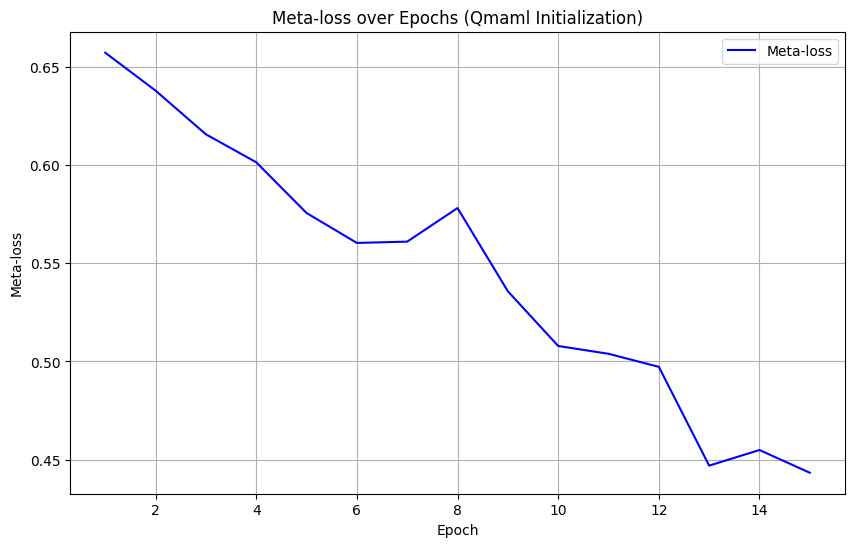

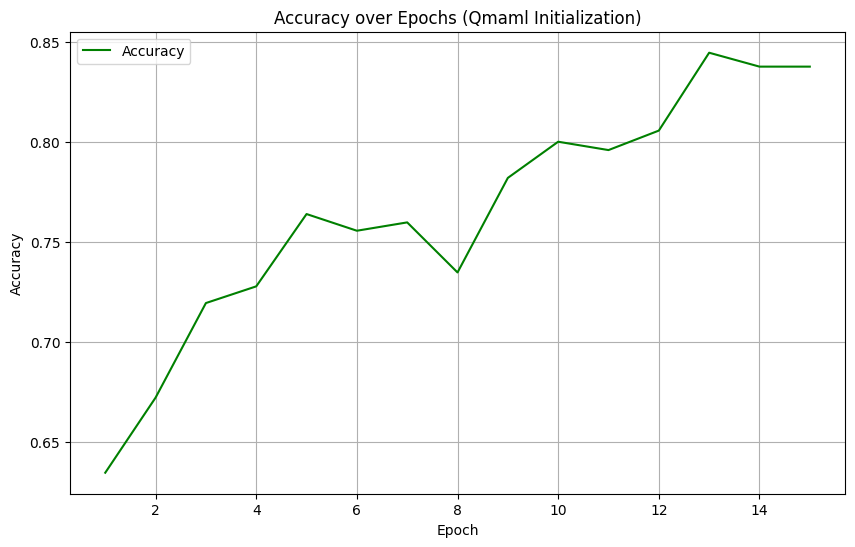

Testing initialization: zero
Epoch 1/15, Meta-loss: 0.6566, Accuracy: 0.5931
Epoch 2/15, Meta-loss: 0.5788, Accuracy: 0.8347
Epoch 3/15, Meta-loss: 0.5378, Accuracy: 0.8306
Epoch 4/15, Meta-loss: 0.4911, Accuracy: 0.8486
Epoch 5/15, Meta-loss: 0.4537, Accuracy: 0.8764
Epoch 6/15, Meta-loss: 0.4403, Accuracy: 0.8736
Epoch 7/15, Meta-loss: 0.4015, Accuracy: 0.8958
Epoch 8/15, Meta-loss: 0.4149, Accuracy: 0.8722
Epoch 9/15, Meta-loss: 0.3614, Accuracy: 0.9097
Epoch 10/15, Meta-loss: 0.3250, Accuracy: 0.9319
Epoch 11/15, Meta-loss: 0.3108, Accuracy: 0.9333
Epoch 12/15, Meta-loss: 0.3690, Accuracy: 0.8903
Epoch 13/15, Meta-loss: 0.3548, Accuracy: 0.8944
Epoch 14/15, Meta-loss: 0.3162, Accuracy: 0.9194
Epoch 15/15, Meta-loss: 0.2981, Accuracy: 0.9236


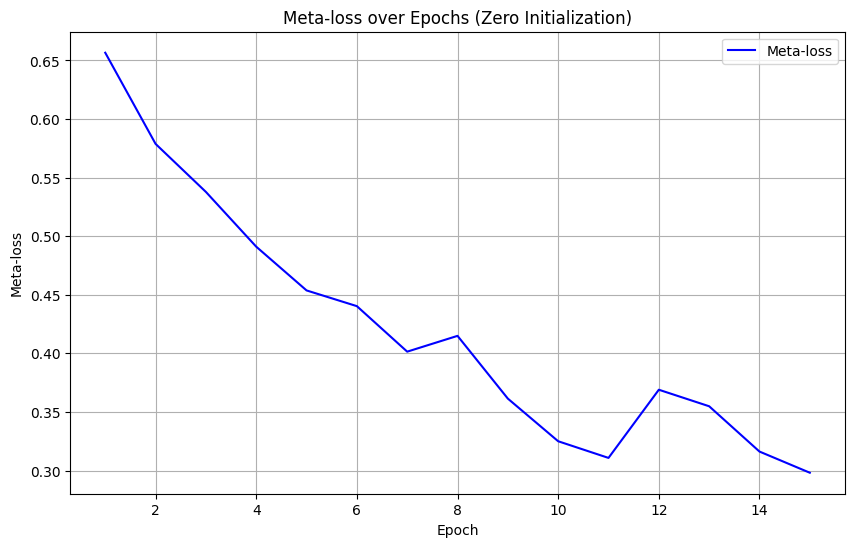

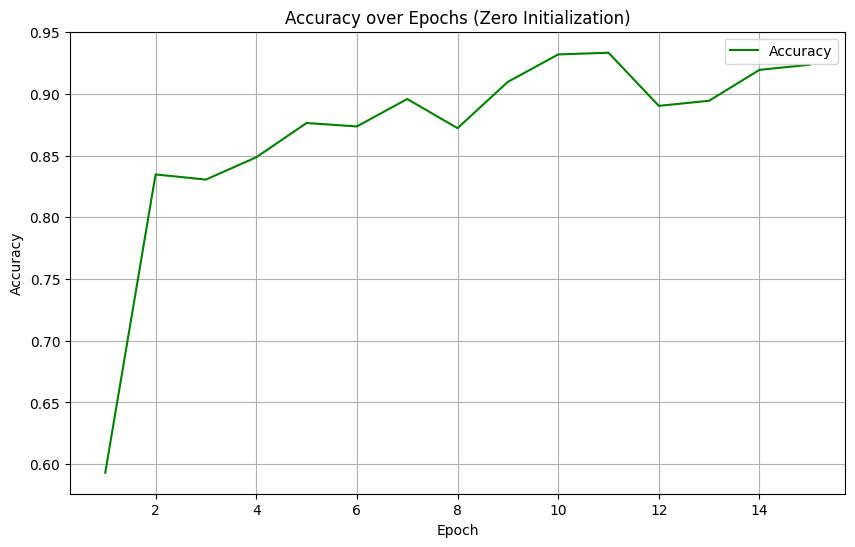

Testing initialization: pi
Epoch 1/15, Meta-loss: 0.6955, Accuracy: 0.5097
Epoch 2/15, Meta-loss: 0.5943, Accuracy: 0.8069
Epoch 3/15, Meta-loss: 0.4852, Accuracy: 0.9028
Epoch 4/15, Meta-loss: 0.4451, Accuracy: 0.8847
Epoch 5/15, Meta-loss: 0.4082, Accuracy: 0.9028
Epoch 6/15, Meta-loss: 0.3574, Accuracy: 0.9264
Epoch 7/15, Meta-loss: 0.3626, Accuracy: 0.9000
Epoch 8/15, Meta-loss: 0.3325, Accuracy: 0.9236
Epoch 9/15, Meta-loss: 0.3477, Accuracy: 0.9000
Epoch 10/15, Meta-loss: 0.2982, Accuracy: 0.9319
Epoch 11/15, Meta-loss: 0.2834, Accuracy: 0.9403
Epoch 12/15, Meta-loss: 0.2658, Accuracy: 0.9472
Epoch 13/15, Meta-loss: 0.2540, Accuracy: 0.9514
Epoch 14/15, Meta-loss: 0.2665, Accuracy: 0.9361
Epoch 15/15, Meta-loss: 0.2832, Accuracy: 0.9264


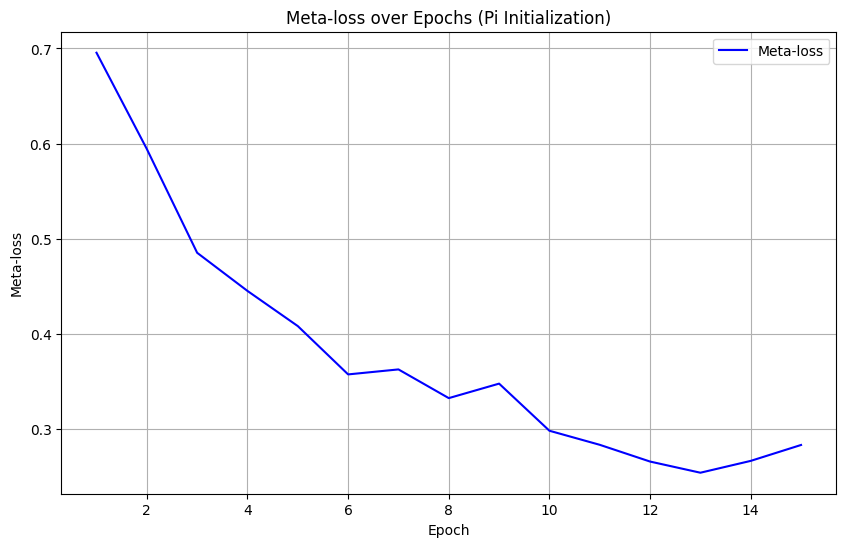

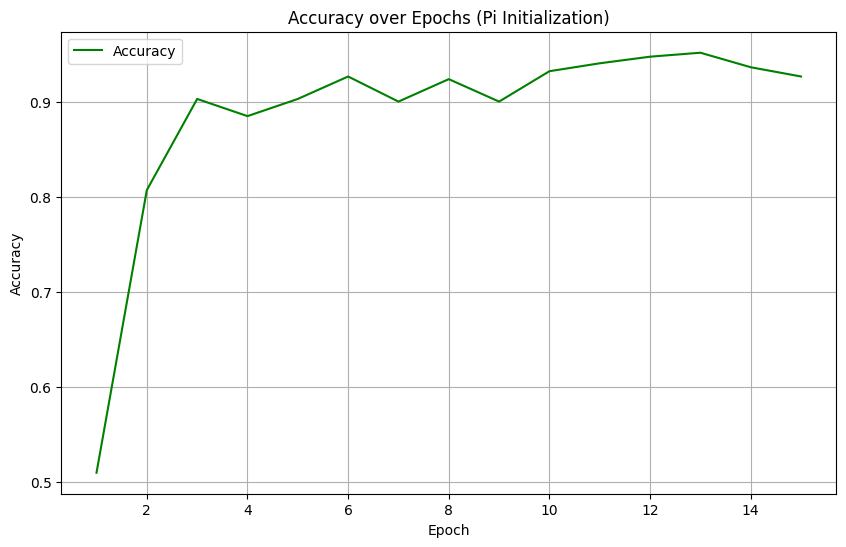

Testing initialization: uniform
Epoch 1/15, Meta-loss: 0.5874, Accuracy: 0.7333
Epoch 2/15, Meta-loss: 0.4139, Accuracy: 0.9181
Epoch 3/15, Meta-loss: 0.3497, Accuracy: 0.9431
Epoch 4/15, Meta-loss: 0.3431, Accuracy: 0.9069
Epoch 5/15, Meta-loss: 0.3405, Accuracy: 0.9056
Epoch 6/15, Meta-loss: 0.3066, Accuracy: 0.9083
Epoch 7/15, Meta-loss: 0.2524, Accuracy: 0.9458
Epoch 8/15, Meta-loss: 0.2714, Accuracy: 0.9222
Epoch 9/15, Meta-loss: 0.3000, Accuracy: 0.8861
Epoch 10/15, Meta-loss: 0.3252, Accuracy: 0.8694
Epoch 11/15, Meta-loss: 0.2623, Accuracy: 0.9250
Epoch 12/15, Meta-loss: 0.2756, Accuracy: 0.9069
Epoch 13/15, Meta-loss: 0.2704, Accuracy: 0.9153


In [ ]:
# --- Cell 11: Run Experiments ---
# Test different initialization techniques
initialization_types = ["qmaml", "zero", "pi", "uniform", "gaussian"]
results = {}

for init_type in initialization_types:
    print(f"Testing initialization: {init_type}")

    # Initialize PQC with the current initialization type
    pqc_model = PQCModel(config.NUM_QUBITS, config.Q_DEPTH, init_type=init_type)

    # Combine CNN and PQC into the hybrid model
    hybrid_model = HybridModel(cnn_extractor, pqc_model)

    # Perform meta-training and store results
    training_results = outer_loop_meta_update(hybrid_model, meta_tasks, config.OUTER_LR, config.EVAL_METRICS)
    results[init_type] = training_results

    # Plot training results for the current initialization
    plot_training_results(training_results, init_type)

# Compare results across all initialization techniques
plot_comparison(results)